In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [60]:
def MLP_pred(filename):
    # Set seed for reproducibility
    torch.manual_seed(0)
    np.random.seed(0)

    # Check if GPU is available and set device accordingly
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load and preprocess the data
    data = pd.read_csv('data/'+filename+'.csv')

    # Select features and target
    features = data[['open', 'high', 'low', 'close', 'change', 'pct_chg', 'vol', 'amount', 'pre_close']]
    target = data['close'].values

    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    # Create sequences with look-back
    def create_sequences(input_data, target, look_back):
        sequences, targets = [], []
        for i in range(len(input_data) - look_back):
            sequences.append(input_data[i:(i + look_back)])
            targets.append(target[i + look_back])
        return np.array(sequences), np.array(targets)

    look_back = 10
    sequences, targets = create_sequences(scaled_features, target, look_back)

    # Split data into train and test sets
    train_size = int(len(sequences) * 0.95)
    test_size = len(sequences) - train_size
    train_sequences, train_targets = sequences[:train_size], targets[:train_size]
    test_sequences, test_targets = sequences[train_size:], targets[train_size:]

    # Convert to PyTorch tensors
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32).to(device)
    train_targets = torch.tensor(train_targets, dtype=torch.float32).to(device)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)

    # Create data loaders
    train_dataset = TensorDataset(train_sequences, train_targets)
    test_dataset = TensorDataset(test_sequences, test_targets)

    batch_size = 64
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Define MLP model
    class MLP(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            return out

    input_dim = look_back * features.shape[1]  # Number of features times look_back
    hidden_dim = 64
    output_dim = 1

    model = MLP(input_dim, hidden_dim, output_dim).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.view(-1, input_dim).to(device)
            labels = labels.view(-1, 1).to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Testing loop
    model.eval()
    with torch.no_grad():
        test_predictions = model(test_sequences.view(-1, input_dim).to(device)).cpu().numpy().flatten()
        test_targets = test_targets.cpu().numpy().flatten()

    # Calculate metrics
    mae = mean_absolute_error(test_targets, test_predictions)
    rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
    r2 = r2_score(test_targets, test_predictions)

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R2 Score: {r2}')

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(test_targets, label='Actual Close Price')
    plt.plot(test_predictions, label='Predicted Close Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
#     plt.show()
    
    plt.savefig('MLP_'+filename+'.png')
    return mae, rmse, r2

MAE: 2.9248077869415283
RMSE: 3.618523120880127
R2 Score: 0.9519418026131682
MAE: 3.586369752883911
RMSE: 9.168684959411621
R2 Score: -27.111099320286204
MAE: 2.363262176513672
RMSE: 3.1543986797332764
R2 Score: 0.9706180712290339
MAE: 2.5886342525482178
RMSE: 3.380439281463623
R2 Score: 0.9600246837764618
MAE: 0.6898546814918518
RMSE: 0.9273034930229187
R2 Score: 0.9889700463262829
MAE: 6.729750156402588
RMSE: 8.338906288146973
R2 Score: 0.8925412140040757
MAE: 6.119461536407471
RMSE: 7.647597312927246
R2 Score: 0.9603458964198684
MAE: 14.034727096557617
RMSE: 18.939348220825195
R2 Score: 0.9791234920007211
MAE: 9.547198295593262
RMSE: 12.014510154724121
R2 Score: 0.8879832828882777
MAE: 1.805690050125122
RMSE: 2.417945623397827
R2 Score: 0.9462140691436411


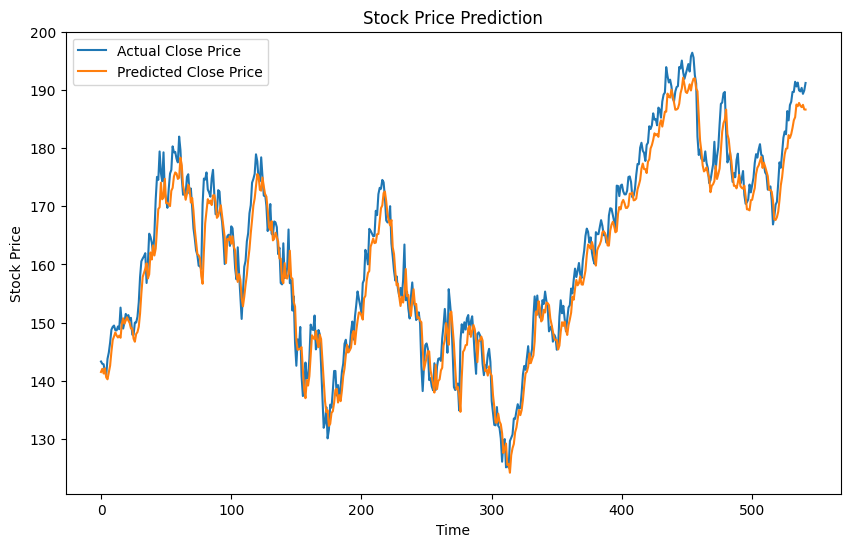

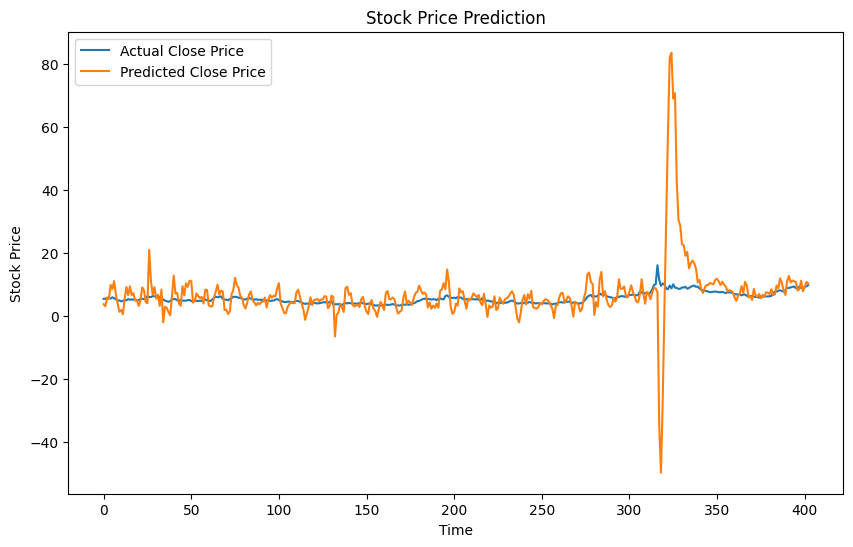

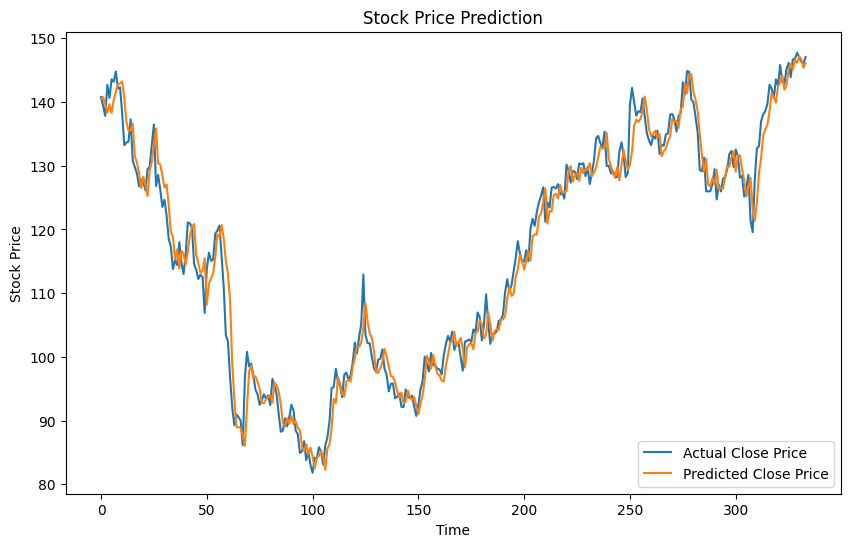

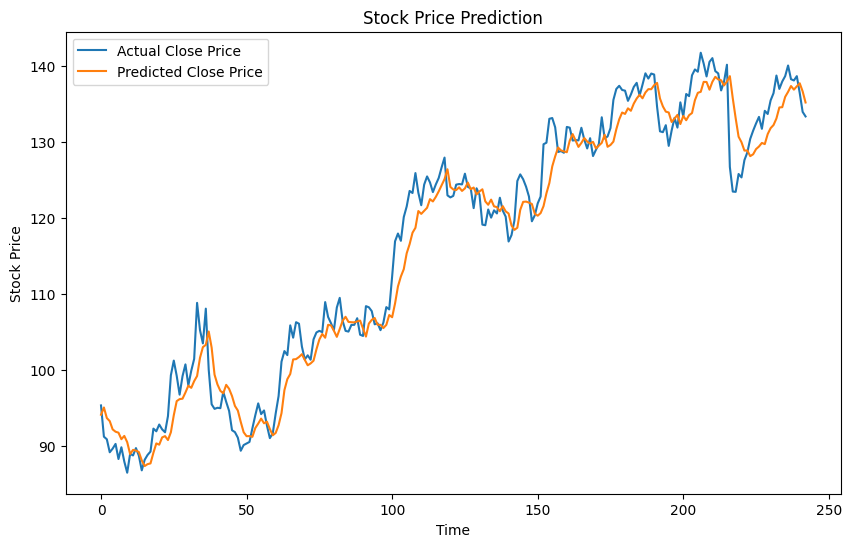

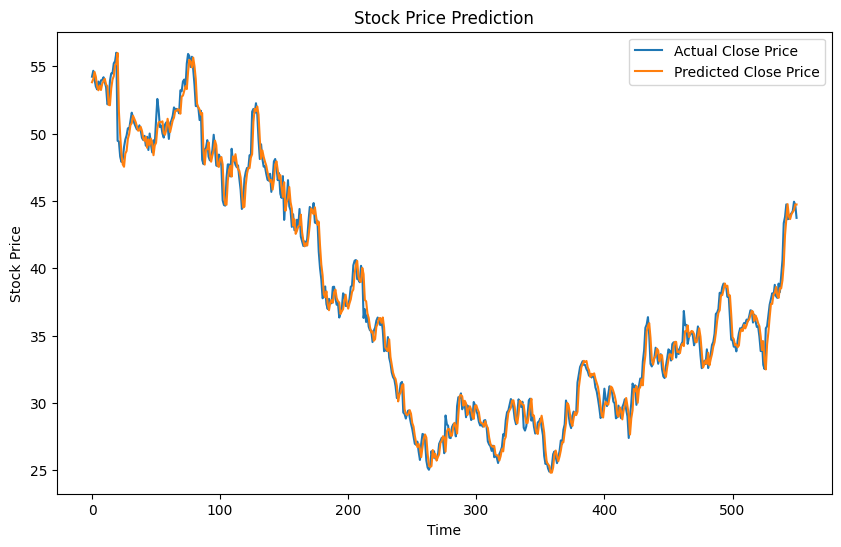

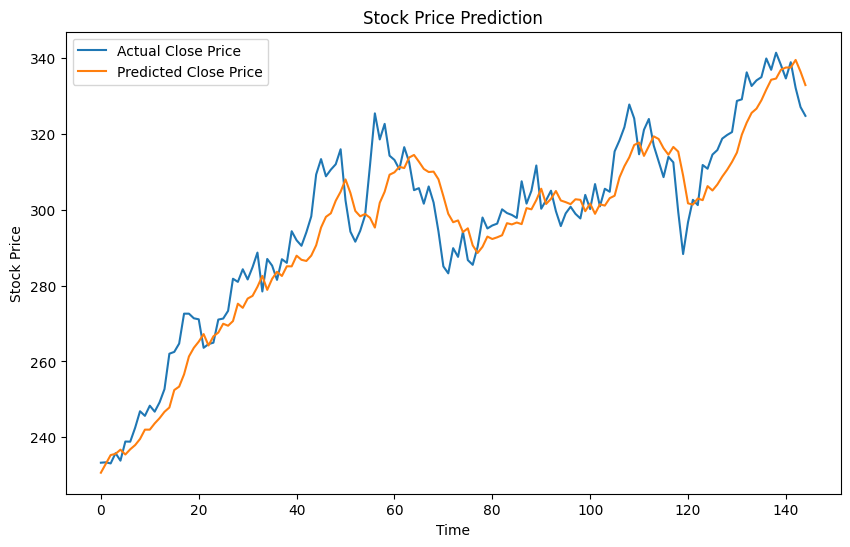

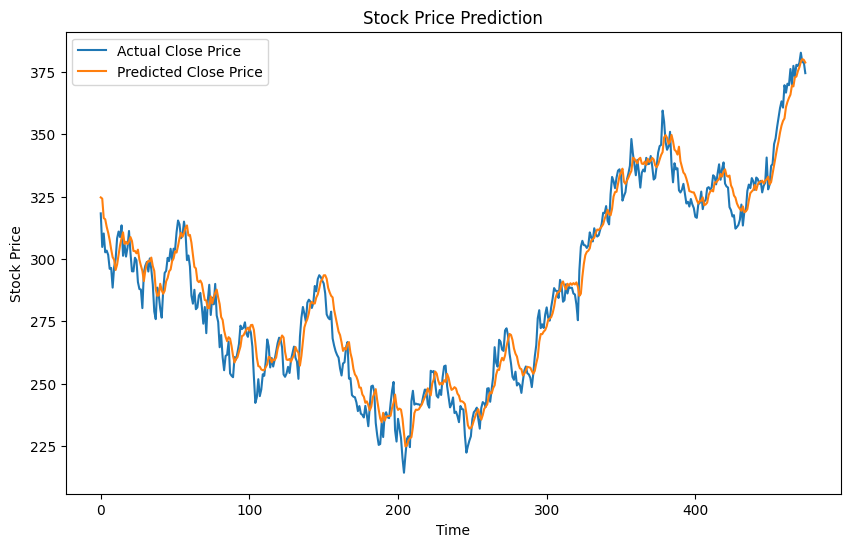

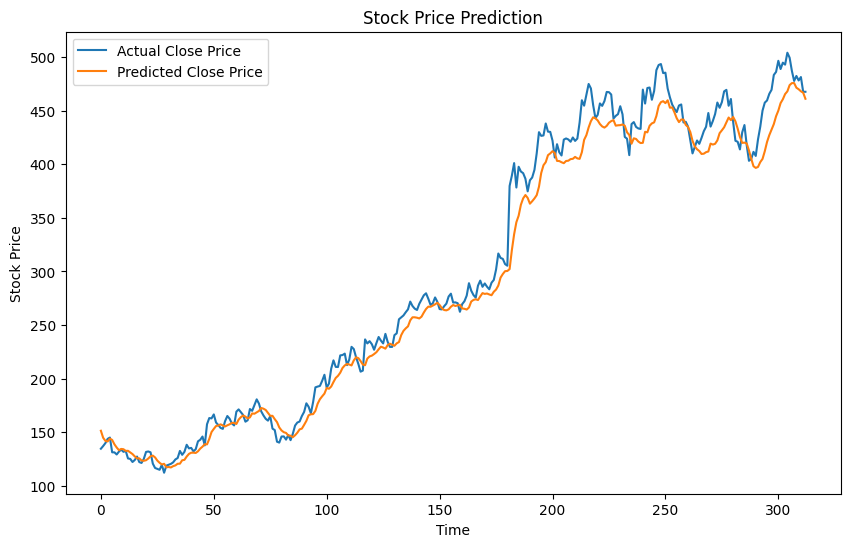

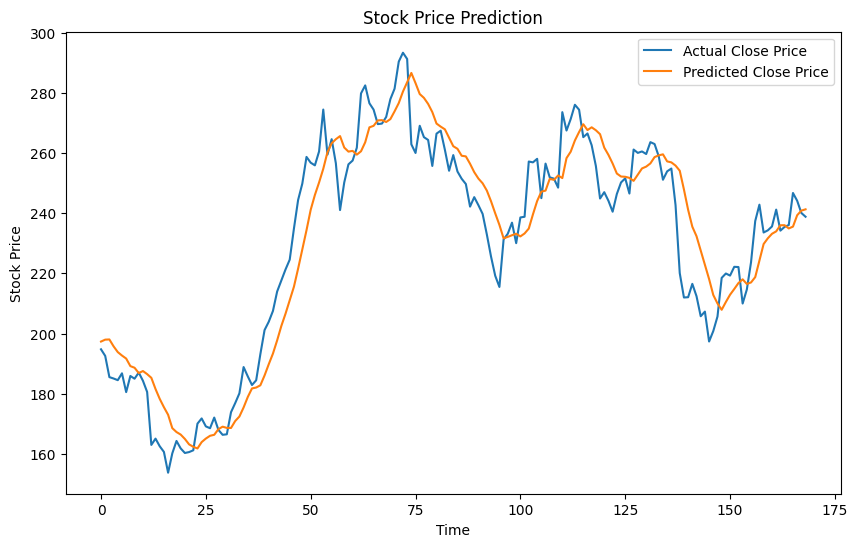

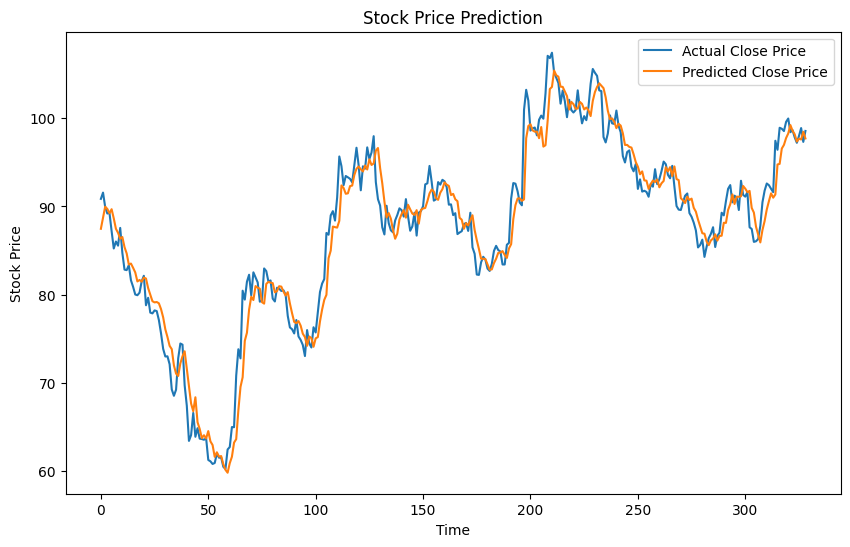

In [61]:
filenames = ['AAPL', 'AMSC', 'AMZN', 'GOOG', 'INTC', 'META', 'MSFT', 'NVDA', 'TSLA', 'TSM']
maes = []
rmses = []
r2s = []
for f in filenames[:]:
    x,y,z = MLP_pred(f)
    maes.append(x)
    rmses.append(y)
    r2s.append(z)

In [62]:
print(np.array(maes).mean())
print(np.array(rmses).mean())
print(np.array([max(i,0) for i in r2s]).mean())

5.0389757
6.960766
0.853776255840153


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [29]:
# Load the dataset
data = pd.read_csv('AAPL.csv')

# Preprocess the data: Convert date to numerical, and scale the data
data['date'] = pd.to_datetime(data['date']).map(pd.Timestamp.timestamp)
x = data.drop(['symbol', 'close'], axis=1).values
y = data['close'].values.reshape(-1, 1)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, shuffle=False)

# Scale the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

# Initialize the model, loss function, and optimizer
model = MLP(x_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [30]:
# Train the model
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs} loss: {loss.item()}')

Epoch 1/200 loss: 595.07275390625
Epoch 11/200 loss: 577.725830078125
Epoch 21/200 loss: 555.5355224609375
Epoch 31/200 loss: 522.0800170898438
Epoch 41/200 loss: 470.8661804199219
Epoch 51/200 loss: 396.0260009765625
Epoch 61/200 loss: 296.556640625
Epoch 71/200 loss: 181.9875946044922
Epoch 81/200 loss: 77.26704406738281
Epoch 91/200 loss: 18.52389144897461
Epoch 101/200 loss: 8.41759967803955
Epoch 111/200 loss: 5.6767377853393555
Epoch 121/200 loss: 2.915616512298584
Epoch 131/200 loss: 2.292085886001587
Epoch 141/200 loss: 1.7811278104782104
Epoch 151/200 loss: 1.5966240167617798
Epoch 161/200 loss: 1.4608396291732788
Epoch 171/200 loss: 1.3689637184143066
Epoch 181/200 loss: 1.290644884109497
Epoch 191/200 loss: 1.2208523750305176


Mean Absolute Error (MAE): 3.1222782139675767
Root Mean Squared Error (RMSE): 5.236843683700662
R-squared Score: 0.8638302138277649


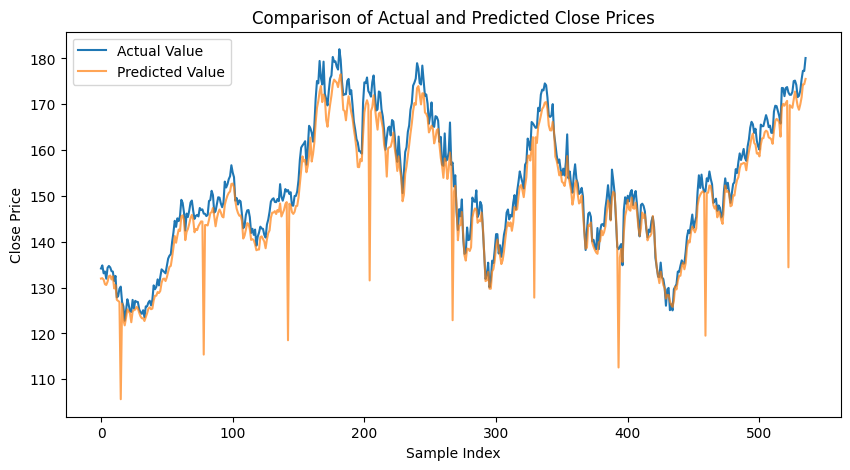

In [35]:
# Evaluate the model
model.eval()
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().numpy()

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared Score: {r2}")

# Visualization of the predicted values and actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Value')
plt.plot(y_pred, label='Predicted Value', alpha=0.7)
plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()